**Intel Image Classification using CNN**

Intel Image Classification consists of a set of images around 25 images of size 150x150. There are six categories:
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street'-> 5}
The problem is a multi-class classification problem


#Download the Data

In [1]:
#The file is located in my google drive 
from google.colab import drive

#mounting google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Checking if file is there
!ls "/content/drive/My Drive/Datasets"

Intel_image_classification.zip


In [3]:
#Unzip file to googlecolab
!mkdir -p '/content/data/Intel'
!unzip '/content/drive/My Drive/Datasets/Intel_image_classification.zip' -d '/content/data/Intel'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/data/Intel/seg_train/seg_train/mountain/7662.jpg  


##Import Data and Visualization##

In [21]:
import tensorflow as tf

assert tf.__version__ >= "2.8.0"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image_dataset
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.image import image_dataset_from_directory as image_dsfd
from PIL import Image
from keras.models import Sequential
from keras.layers.normalization import batch_normalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split
import random


Some sample images from the training Sea directory

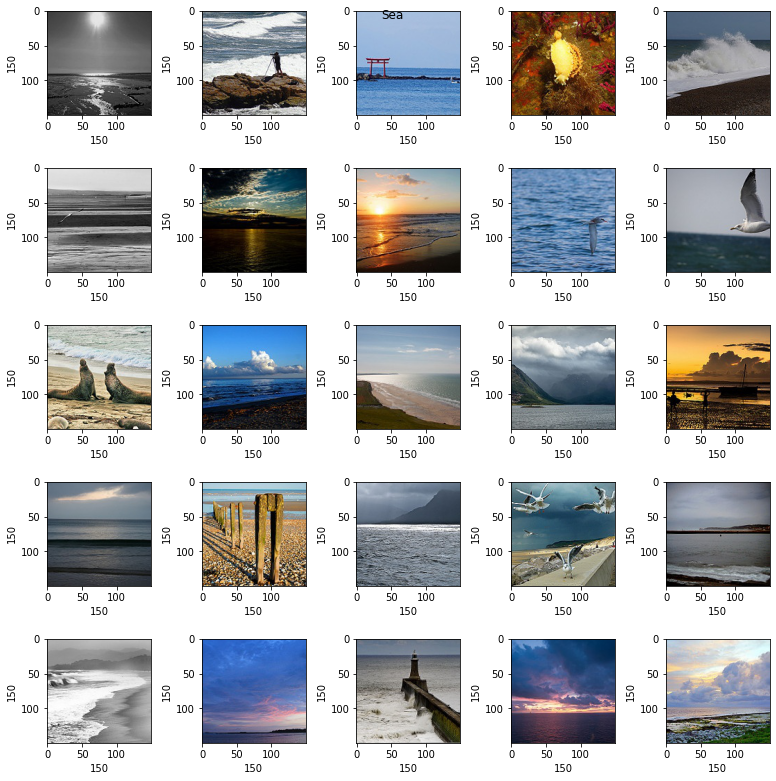

In [ ]:

plt.figure(figsize=(11,11))
path = "/content/data/Intel/seg_train/seg_train/sea"
#random.choice chooses a random value in the list 
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(listdir(path))))
  plt.imshow(rand_img)
  plt.axis('off')


Loading images using directory names as labels

In [5]:
train = image_dataset.image_dataset_from_directory(
    directory ='/content/data/Intel/seg_train/seg_train',
    image_size=(150,150),
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    label_mode = 'categorical'
)

validation = image_dataset.image_dataset_from_directory(
    directory ='/content/data/Intel/seg_train/seg_train',
    image_size=(150,150),
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    label_mode = 'categorical'
)

test = image_dataset.image_dataset_from_directory(
    directory ='/content/data/Intel/seg_test/seg_test',
    image_size=(150,150),
    label_mode = 'categorical'
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


Checking for Data Imabalances

In [14]:
train_path = '/content/data/Intel/seg_train/seg_train'

for cat in listdir(train_path):
  pth = train_path+ '/'+cat
  dir_size = listdir(pth)
  print(f"{cat} has {len(dir_size)} elements: ratio {len(dir_size)/14034}")

sea has 2274 elements: ratio 0.16203505771697307
street has 2382 elements: ratio 0.16973065412569474
forest has 2271 elements: ratio 0.16182129115006413
glacier has 2404 elements: ratio 0.17129827561636027
mountain has 2512 elements: ratio 0.17899387202508193
buildings has 2191 elements: ratio 0.15612084936582585


Training set data with labels

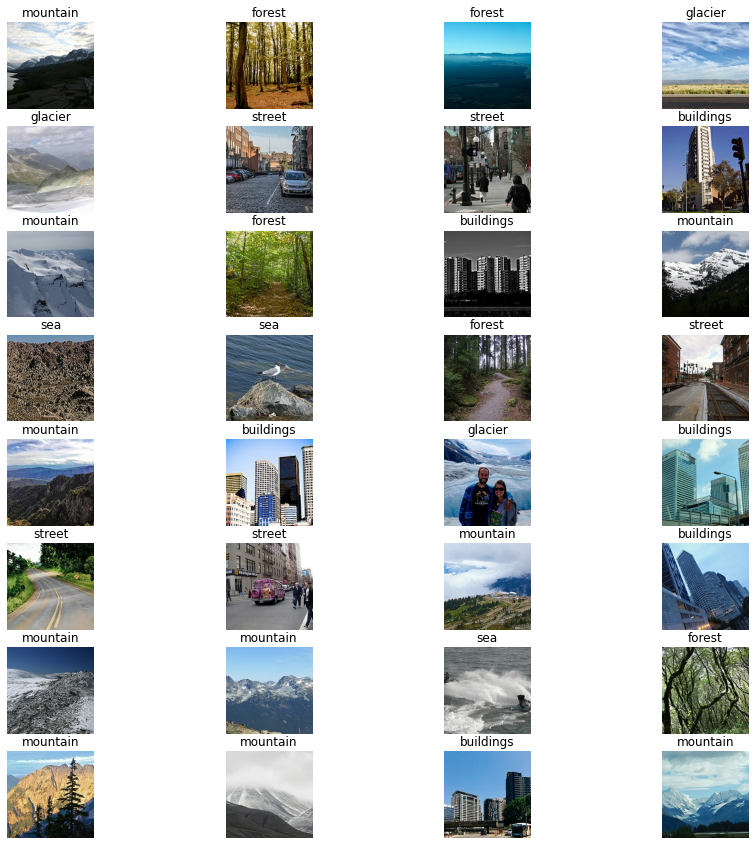

In [7]:
plt.figure(figsize=(15,15))
class_names = train.class_names

for images, labels in train.skip(1).take(1):
  for i in range(32):
      image = images[i].numpy().astype("uint8")
      label = labels[i].numpy().astype("uint8")
      idx = np.where(label==1)
      plt.subplot(8,4, i+1)
      plt.imshow(image)
      plt.title(class_names[idx[0][0]])
      plt.axis("off")

#Train a Baseline Model#

In [8]:
from keras.layers import BatchNormalization
import keras.optimizers

model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),
          
        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),
        
        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),
    
        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
    
        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),
    
        Dense(6, activation = 'softmax')    
        ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 146, 146, 32)      0

Added Recall and Precision as Metrics

In [29]:


model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam',metrics=['accuracy',keras.metrics.Recall(),keras.metrics.Precision()])

In [30]:
# Training the model
epochs = 70
batch_size = 128
history = model.fit(train, validation_data = validation , batch_size = batch_size, epochs = epochs)

Epoch 1/70
351/351 [==============================] - 18s 46ms/step - loss: 0.9526 - accuracy: 0.6533 - recall_2: 0.4958 - precision_1: 0.7582 - val_loss: 0.6411 - val_accuracy: 0.7676 - val_recall_2: 0.7153 - val_precision_1: 0.8086
Epoch 2/70
351/351 [==============================] - 16s 46ms/step - loss: 0.6738 - accuracy: 0.7610 - recall_2: 0.6770 - precision_1: 0.8169 - val_loss: 0.9047 - val_accuracy: 0.6960 - val_recall_2: 0.6629 - val_precision_1: 0.7343
Epoch 3/70
351/351 [==============================] - 16s 46ms/step - loss: 0.6142 - accuracy: 0.7846 - recall_2: 0.7257 - precision_1: 0.8286 - val_loss: 0.8303 - val_accuracy: 0.6924 - val_recall_2: 0.6632 - val_precision_1: 0.7160
Epoch 4/70
351/351 [==============================] - 16s 44ms/step - loss: 0.5538 - accuracy: 0.8074 - recall_2: 0.7586 - precision_1: 0.8498 - val_loss: 0.5082 - val_accuracy: 0.8118 - val_recall_2: 0.7840 - val_precision_1: 0.8413
Epoch 5/70
351/351 [==============================] - 16s 44ms/s

In [36]:
# Saving model
model.save("/content/drive/My Drive/Colab Notebooks/intel_image.h5")

In [41]:
historyDF = pd.DataFrame(history.history)


In [43]:
historyDF.to_csv(index=False)


'loss,accuracy,recall_2,precision_1,val_loss,val_accuracy,val_recall_2,val_precision_1\n0.9526491761207581,0.6532775163650513,0.4958140254020691,0.758240282535553,0.6410574913024902,0.7676407694816589,0.7152530550956726,0.8086220622062683\n0.6737861633300781,0.7610438466072083,0.6769682765007019,0.8168726563453674,0.9047026038169861,0.696008563041687,0.6628652811050415,0.7343071699142456\n0.6141660809516907,0.7845564484596252,0.7256857752799988,0.8286382555961609,0.8303455710411072,0.6924447417259216,0.6632216572761536,0.7160446047782898\n0.5538073182106018,0.807356595993042,0.7585500478744507,0.8498303890228271,0.5081652402877808,0.8118317723274231,0.7840341925621033,0.8413001894950867\n0.5221893787384033,0.8185785412788391,0.7784110903739929,0.8567787408828735,0.6530383825302124,0.7676407694816589,0.7419814467430115,0.7910334467887878\n0.47735825181007385,0.8369255661964417,0.8009440898895264,0.8679664134979248,0.42979422211647034,0.8410548567771912,0.8164647221565247,0.8678030371665